<a href="https://colab.research.google.com/github/MadSlingshoter/Artificial-intelligence-for-data-science-/blob/main/Lab4/lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Detection Classifier Lab: Implementing a Compact Language Detector (Inspired by Google's CLD3)

**Welcome to Lab 4!** This lab guides you through building a language classifier using n-gram features and the "hashing trick" for efficient feature representation. We'll reimplement key ideas from Google's Compact Language Detector (CLD3) using the Tatoeba dataset (downsampled for this lab).

### Learning Objectives
- Understand n-gram extraction and feature hashing for text classification.
- Implement data processing pipelines (unigrams, bigrams, trigrams → hashed vectors).
- Train and evaluate baseline models: Logistic Regression and a simple Neural Network.
- Experiment with encodings: Boolean (presence) vs. Relative Frequencies.
- (Optional) Extend to learnable embeddings.

### Dataset
- **Source**: Tatoeba (sentences + translations, downsampled to ~31k train, ~4k val/test sentences across 39 languages).
- **Format**: TSV files (`train.tsv`, `val.tsv`, `test.tsv`) with columns: [ID, Language Code, Sentence].
- **Access**: The notebook auto-downloads from the course GitHub repo if not local.

### Setup Instructions
1. Clone the repo: `git clone https://github.com/Azadshokrollahi/Artificial-intelligence-for-data-science-.git`
2. Navigate: `cd Lab4`
3. Run: `jupyter notebook language_detector_student.ipynb`
4. The notebook handles dataset fetching automatically.

**Run the cells step-by-step. Fill in the blanks marked with `# TODO: Student Task` and test your implementations.**

In [1]:
# === Dataset Locator (Auto-download from GitHub if needed) ===
from pathlib import Path
import os
import urllib.request  # For downloading if needed

FILENAME_TRAIN = "train.tsv"
FILENAME_VAL   = "val.tsv"
FILENAME_TEST  = "test.tsv"

# Candidate locations if you run the notebook from different folders
CANDIDATES = [
    Path("small_dataset"),
    Path("Lab4") / "small_dataset",
    Path.cwd() / "small_dataset",
    Path.cwd() / "Lab4" / "small_dataset",
]

dataset_dir = next((p for p in CANDIDATES if (p / FILENAME_TRAIN).exists()
                    and (p / FILENAME_VAL).exists()
                    and (p / FILENAME_TEST).exists()), None)

# If not found locally, download directly from Azad's GitHub repo into ./small_dataset
if dataset_dir is None:
    print("[INFO] Local small_dataset not found. Downloading from GitHub repo...")
    dataset_dir = Path("small_dataset")
    dataset_dir.mkdir(parents=True, exist_ok=True)

    base = "https://raw.githubusercontent.com/Azadshokrollahi/Artificial-intelligence-for-data-science-/main/Lab4/small_dataset"
    for fname in [FILENAME_TRAIN, FILENAME_VAL, FILENAME_TEST]:
        url = f"{base}/{fname}"
        out = dataset_dir / fname
        print(f"  ↳ {fname} ← {url}")
        urllib.request.urlretrieve(url, out)

# Final resolved files
FILE_TRAIN = str(dataset_dir / FILENAME_TRAIN)
FILE_VAL   = str(dataset_dir / FILENAME_VAL)
FILE_TEST  = str(dataset_dir / FILENAME_TEST)

print("[INFO] Using small dataset at:", dataset_dir.resolve())
print("       Train:", FILE_TRAIN)
print("       Val  :", FILE_VAL)
print("       Test :", FILE_TEST)

# === Preliminaries ===
import random
import hashlib
from collections import Counter
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

random.seed(4321)
torch.manual_seed(4321)

[INFO] Local small_dataset not found. Downloading from GitHub repo...
  ↳ train.tsv ← https://raw.githubusercontent.com/Azadshokrollahi/Artificial-intelligence-for-data-science-/main/Lab4/small_dataset/train.tsv
  ↳ val.tsv ← https://raw.githubusercontent.com/Azadshokrollahi/Artificial-intelligence-for-data-science-/main/Lab4/small_dataset/val.tsv
  ↳ test.tsv ← https://raw.githubusercontent.com/Azadshokrollahi/Artificial-intelligence-for-data-science-/main/Lab4/small_dataset/test.tsv
[INFO] Using small dataset at: /content/small_dataset
       Train: small_dataset/train.tsv
       Val  : small_dataset/val.tsv
       Test : small_dataset/test.tsv


## Cell 2: Settings and Language Indexing
Define hyperparameters and create language-to-index mappings.

In [2]:
# Settings
SMALL_DATASET_PATH = 'small_dataset'  # Already resolved above

REL_FREQ = True  # TODO: Experiment: Set to False for Boolean encoding (presence only)
HIDDEN_LAYER = False  # TODO: Experiment: Set to True for Neural Network with hidden layer
HIDDEN_DIM = 512  # Hidden layer size (only used if HIDDEN_LAYER=True)
EPOCHS = 10
BATCH_SIZE = 32

dataset_path = SMALL_DATASET_PATH
FILE_TRAIN = dataset_path + '/' + FILENAME_TRAIN
FILE_VAL = dataset_path + '/' + FILENAME_VAL
FILE_TEST = dataset_path + '/' + FILENAME_TEST

# File reader generator
def file_reader(file):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            yield tuple(row.split('\t'))

# Count languages in train
line_generator = file_reader(FILE_TRAIN)
lang_freqs = Counter(map(lambda x: x[1], line_generator))
langs = sorted(list(set(lang_freqs.keys())))

# TODO============================== Student Task 1 - Create idx2lang: A dictionary mapping indices (0 to len(langs)-1) to language codes
# Example: {0: 'ara', 1: 'ber', ...}
idx2lang = dict(zip(range(len(langs)), langs))

# TODO==============================: Student Task 2 - Create lang2idx: The reverse mapping (language code to index)
# Example: {'ara': 0, 'ber': 1, ...}
lang2idx = dict(zip(langs, range(len(langs))))

print(f"[INFO] Detected {len(langs)} languages: {langs[:5]}...")
print("Sample idx2lang:", dict(list(idx2lang.items())[:5]))
print("Sample lang2idx:", dict(list(lang2idx.items())[:5]))

[INFO] Detected 39 languages: ['ara', 'ber', 'bul', 'ces', 'cmn']...
Sample idx2lang: {0: 'ara', 1: 'ber', 2: 'bul', 3: 'ces', 4: 'cmn'}
Sample lang2idx: {'ara': 0, 'ber': 1, 'bul': 2, 'ces': 3, 'cmn': 4}


## Cell 3: N-Gram Extraction and Hashing
Extract unigrams/bigrams/trigrams and hash them into fixed-size indices.

In [4]:
# N-grams extraction
# TODO: Student Task - Implement ngrams: Extract all n-length substrings from sentence.
# Args: sentence (str), n (int=1), lc (bool=True) - lowercase if True.
# Return: List of n-grams (str), e.g., ngrams('banana', 2) -> ['ba', 'an', 'na', 'an', 'na']
# Hint: Use a loop over range(len(s) - n + 1), slice s[i:i+n]
def ngrams(sentence, n=1, lc=True):
    ngram_l = []
    s = sentence.lower() if lc else sentence
    # Task 3============================ TODO: Your code here
    for i in range(len(s) - n + 1):
        ngram_l += [s[i:i+n]]
    return ngram_l


def all_ngrams(sentence, max_ngram=3, lc=True):
    all_ngram_list = []
    for i in range(1, max_ngram + 1):
        all_ngram_list += [ngrams(sentence, n=i, lc=lc)]
    return all_ngram_list

# Test your implementation
print("Test ngrams('banana', 2):", ngrams('banana', 2))
print("Test all_ngrams('banana'):", all_ngrams('banana'))
# Expected: [['b', 'a', 'n', 'a', 'n', 'a'], ['ba', 'an', 'na', 'an', 'na'], ['ban', 'ana', 'nan', 'ana']]

# Hashing
def reproducible_hash(string):
    h = hashlib.md5(string.encode("utf-8"), usedforsecurity=False)
    return int.from_bytes(h.digest()[0:8], 'big', signed=True)

# Modulos for feature space (Fixed to small dataset values)
MAX_CHARS = 521
MAX_BIGRAMS = 1031
MAX_TRIGRAMS = 1031
NUM_FEATURES = MAX_CHARS + MAX_BIGRAMS + MAX_TRIGRAMS
MAXES = [MAX_CHARS, MAX_BIGRAMS, MAX_TRIGRAMS]

print(f"[INFO] Feature space size: {NUM_FEATURES} (chars: {MAX_CHARS}, bigrams: {MAX_BIGRAMS}, trigrams: {MAX_TRIGRAMS})")

# TODO: Student Task - Implement hash_ngrams: Hash each n-gram list into indices modulo respective MAX.
# Args: ngram_lists (list of 3 lists: unigrams, bigrams, trigrams), modulos (list of 3 MAX values).
# Return: List of 3 lists: hashed indices, e.g., [[hash('b') % 521, ...], ...]
# Hint: Loop over zip(ngram_lists, modulos), use list comprehension with reproducible_hash % modulo
def hash_ngrams(ngram_lists, modulos):
    hash_codes = []
    # Task 4============================== TODO: Your code here
    for ngram_list, modulo in zip(ngram_lists, modulos):
        hash_codes += [[reproducible_hash(ngram) % modulo for ngram in ngram_list]]
    return hash_codes


# Test
hash_banana = hash_ngrams(all_ngrams('banana'), MAXES)
print("Test hash_ngrams('banana'):", hash_banana[:2])  # First 2 for brevity

Test ngrams('banana', 2): ['ba', 'an', 'na', 'an', 'na']
Test all_ngrams('banana'): [['b', 'a', 'n', 'a', 'n', 'a'], ['ba', 'an', 'na', 'an', 'na'], ['ban', 'ana', 'nan', 'ana']]
[INFO] Feature space size: 2583 (chars: 521, bigrams: 1031, trigrams: 1031)
Test hash_ngrams('banana'): [[25, 234, 310, 234, 310, 234], [994, 649, 808, 649, 808]]


## Cell 4: Relative Frequencies and Multihot Vectors
Compute n-gram frequencies and encode as sparse vectors.

In [5]:
# TODO: Student Task - Implement rel_freqs: Compute relative frequencies of items in lst.
# Args: lst (list of hashes).
# Return: Dict {hash: freq} where freq = count / len(lst), e.g., Counter then normalize.
# Hint: Use collections.Counter, then {k: v / total for k,v in counter.items()}
def rel_freqs(lst):
    #  Task 5========================= TODO: Your code here
    counter = Counter(lst)
    return {k: v / len(lst) for k, v in counter.items()}


# Test
freqs_banana = [rel_freqs(x) for x in hash_banana]
print("Test rel_freqs (chars):", freqs_banana[0])
# Expected: {25: 0.1667, 234: 0.5, 310: 0.3333, ...}

# Multihot vectors (Boolean version)
# TODO: Student Task - Implement multihot: Create torch vector of size 'max' with 1.0 at dict keys, else 0.0.
# Args: idx_freq (dict, but ignore values), max (int).
# Return: torch.zeros(max) with feat_vector[idx] = 1.0 for idx in keys.
def multihot(idx_freq, max_size):
    feat_vector = torch.zeros(max_size)
    #  Task 6=================================== TODO: Your code here
    for idx in idx_freq.keys():
        feat_vector[idx] = 1.0
    return feat_vector


# Multihot with frequencies
# TODO: Student Task - Implement multihot_freq: Like multihot, but set feat_vector[idx] = freq from dict values.
def multihot_freq(idx_freq, max_size):
    feat_vector = torch.zeros(max_size)
    #  Task 7============================== TODO: Your code here
    for idx, freq in idx_freq.items():
        feat_vector[idx] = freq
    return feat_vector


# Test
mhot_char = multihot(freqs_banana[0], MAX_CHARS)
print("Nonzero indices (multihot):", torch.nonzero(mhot_char).squeeze().tolist())
freq_char = multihot_freq(freqs_banana[0], MAX_CHARS)
print("Values at nonzero (multihot_freq):", freq_char[torch.nonzero(freq_char)].tolist())
# Expected: Indices [25,234,310]; Values [0.1667, 0.5, 0.3333]

Test rel_freqs (chars): {25: 0.16666666666666666, 234: 0.5, 310: 0.3333333333333333}
Nonzero indices (multihot): [25, 234, 310]
Values at nonzero (multihot_freq): [[0.1666666716337204], [0.5], [0.3333333432674408]]


## Cell 5: Data Loading and Tensor Creation
Load sentences into X (features) and y (labels).

In [6]:
# Data loader
def read_sent_lang(file):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            lang_tuple = tuple(row.split('\t'))
            yield lang_tuple[2], lang_tuple[1]   # sentence, lang

# Process file into X (N x NUM_FEATURES tensor), y (N tensor of indices).
# Steps:
# 1. Count lines for X size (pre-allocate).
# 2. Loop over read_sent_lang: Extract all_ngrams → hash_ngrams → [rel_freqs each] → [multihot_func each] → torch.cat → X[i]
# 3. Map langs to indices with lang2idx → torch.LongTensor(y_symb)
# Use tqdm for progress. Handle via multihot_func (freq or bool).
def create_Xy(file, multihot_func, lang2idx):
    line_cnt = 0
    for sentence, lang in read_sent_lang(file):
        line_cnt += 1
    X = torch.empty((line_cnt, NUM_FEATURES))
    y_symb = []
    for i, (sentence, lang) in tqdm(enumerate(read_sent_lang(file)), total=line_cnt, desc="Processing"):
        # TODO: Your code here - extract ngrams, hash, freqs, multihot, cat to X[i]
        hashes = hash_ngrams(all_ngrams(sentence), MAXES)
        hash_freq_l = list(map(rel_freqs, hashes))
        x_row_l = []
        for hash_freq_dict, max_val in zip(hash_freq_l, MAXES):
            x_row_l += [multihot_func(hash_freq_dict, max_val)]
        X[i, :] = torch.cat(x_row_l, -1)
        y_symb += [lang]
    y = torch.LongTensor(list(map(lang2idx.get, y_symb)))
    return X, y

# Create datasets
multihot_func = multihot_freq if REL_FREQ else multihot
X_train, y_train = create_Xy(FILE_TRAIN, multihot_func, lang2idx)
X_val, y_val = create_Xy(FILE_VAL, multihot_func, lang2idx)
X_test, y_test = create_Xy(FILE_TEST, multihot_func, lang2idx)

input_dim = X_train.size()[1]
print(f"[INFO] Dataset shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("Sample y_train:", y_train[:10])

Processing: 100%|██████████| 3923/3923 [00:02<00:00, 1501.06it/s]

[INFO] Dataset shapes - Train: torch.Size([31376, 2583]), Val: torch.Size([3922, 2583]), Test: torch.Size([3923, 2583])
Sample y_train: tensor([37, 28, 25, 21, 15, 24,  9, 38, 21, 16])


## Cell 6: Model Architectures
Define Logistic Regression or Neural Net.

In [8]:
# Models
# TODO: Student Task - Define two architectures using nn.Sequential.
# If HIDDEN_LAYER: Linear(input_dim → HIDDEN_DIM) → ReLU → Linear(HIDDEN_DIM → num_langs)
# Else: Linear(input_dim → num_langs)  # Logistic Regression
if HIDDEN_LAYER:
    model = nn.Sequential(
        #  Task 8 ====================TODO: Your code here
        nn.Linear(input_dim, HIDDEN_DIM),
        nn.ReLU(),
        nn.Linear(HIDDEN_DIM, len(langs))
    )
else:
    model = nn.Sequential(
        #  Task 9====================TODO: Your code here
        nn.Linear(input_dim, len(langs))
    )

print(f"[INFO] Model: {'Neural Network (hidden dim=' + str(HIDDEN_DIM) + ')' if HIDDEN_LAYER else 'Logistic Regression'}")
print(f"Output classes: {len(langs)}")

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)

# DataLoader for batches
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

[INFO] Model: Logistic Regression
Output classes: 39


## Cell 7: Training Loop
Train the model with validation.

Training:  20%|██        | 2/10 [00:05<00:22,  2.83s/it]

Epoch 2: Train Acc: 0.9474, Val Acc: 0.9393


Training:  40%|████      | 4/10 [00:09<00:13,  2.24s/it]

Epoch 4: Train Acc: 0.9680, Val Acc: 0.9462


Training:  60%|██████    | 6/10 [00:13<00:08,  2.16s/it]

Epoch 6: Train Acc: 0.9787, Val Acc: 0.9472


Training:  80%|████████  | 8/10 [00:18<00:04,  2.37s/it]

Epoch 8: Train Acc: 0.9861, Val Acc: 0.9495


Training: 100%|██████████| 10/10 [00:23<00:00,  2.32s/it]

Epoch 10: Train Acc: 0.9908, Val Acc: 0.9523


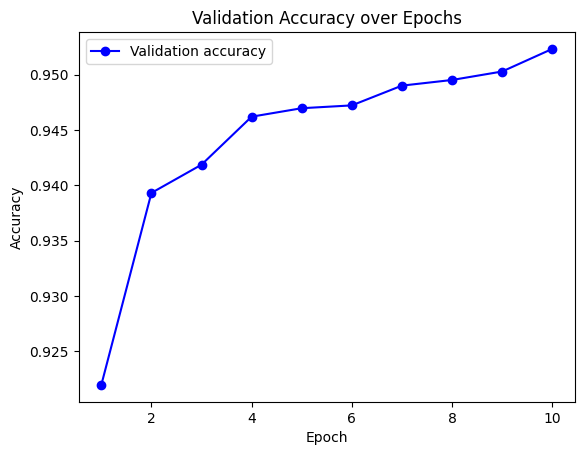

In [9]:
# Training loop
loss_train_history = []
acc_train_history = []
loss_val_history = []
acc_val_history = []
for epoch in tqdm(range(EPOCHS), desc="Training"):
    # Training phase
    loss_train_epoch = 0.0
    correct_train = 0
    total_train = 0
    model.train()  # Enable dropout/etc. (if any)
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        loss_train_epoch += loss.item() * len(X_batch)
        _, predicted = torch.max(y_pred.data, 1)
        total_train += len(y_batch)
        correct_train += (predicted == y_batch).sum().item()

    avg_loss_train = loss_train_epoch / len(dataloader.dataset)
    acc_train = correct_train / total_train

    # Task 10======================TODO: Student Task - Add validation phase: model.eval(), no_grad(), predict on X_val, compute loss/acc.
    # Append to histories. Print every 2 epochs.
    # Hint: Reuse train logic but without gradients/optimizer
    model.eval()
    #your code
    with torch.no_grad():
        loss_val_epoch = 0.0
        correct_val = 0
        total_val = 0
        for X_batch, y_batch in DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False):
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss_val_epoch += loss.item() * len(X_batch)
            _, predicted = torch.max(y_pred.data, 1)
            total_val += len(y_batch)
            correct_val += (predicted == y_batch).sum().item()

    loss_val = loss_val_epoch / len(dataloader.dataset)
    acc_val = correct_val / total_val



    loss_train_history.append(avg_loss_train)
    acc_train_history.append(acc_train)
    loss_val_history.append(loss_val)
    acc_val_history.append(acc_val)

    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}: Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}")

# Plot
epochs_range = range(1, len(acc_val_history) + 1)
plt.plot(epochs_range, acc_val_history, 'bo-', label='Validation accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Cell 8: Evaluation and Inference
Test the model and demo detector.

In [10]:
# Test predictions
model.eval()
with torch.no_grad():
    # TODO: Student Task - Predict: y_test_pred = argmax(model(X_test), dim=1)
    y_test_pred = torch.argmax(model(X_test), dim=1)  # Your code here

print("\n=== Test Results ===")
print(classification_report(y_test, y_test_pred, target_names=langs, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Detector function (for new text)
def encode(text, multihot_func, MAXES):
    hashes = hash_ngrams(all_ngrams(text), MAXES)
    hash_freq_l = list(map(rel_freqs, hashes))
    x_row = torch.empty((0,))
    for hash_freq_dict, max_val in zip(hash_freq_l, MAXES):
        x_row = torch.hstack((x_row, multihot_func(hash_freq_dict, max_val)))
    return x_row

# Example predictions
print("\n=== Example Predictions ===")
test_sents = ['Hi guys and girls!', 'Hur mår du nu?', 'Allt bra idag?', 'Salut tout le monde !']
for sent in test_sents:
    row = encode(sent, multihot_func, MAXES)
    pred_lang = idx2lang[torch.argmax(model(row), dim=-1).item()]
    print(f"'{sent}' → {pred_lang}")

# Verification: Instructor example (Swedish: 'swe')
example_sent = "Stanna!"
row_example = encode(example_sent, multihot_func, MAXES)
pred_example = idx2lang[torch.argmax(model(row_example), dim=-1).item()]
print(f"\nVerification: 'Stanna!' → {pred_example} (expected: swe)")


=== Test Results ===
              precision    recall  f1-score   support

         ara     1.0000    0.9886    0.9943        88
         ber     0.7097    0.6735    0.6911        98
         bul     0.8980    0.8800    0.8889       100
         ces     0.9670    0.9670    0.9670        91
         cmn     0.9905    1.0000    0.9952       104
         dan     0.9340    0.8919    0.9124       111
         deu     0.9780    0.9889    0.9834        90
         ell     1.0000    1.0000    1.0000       106
         eng     0.9694    0.9794    0.9744        97
         epo     0.9663    0.9885    0.9773        87
         fin     0.9730    0.9908    0.9818       109
         fra     0.9785    0.9891    0.9838        92
         hau     0.9694    0.9896    0.9794        96
         heb     1.0000    1.0000    1.0000        99
         hun     1.0000    0.9798    0.9898        99
         ina     0.9196    0.9810    0.9493       105
         ita     0.9439    0.9619    0.9528       105
     

## Cell 9: Results and Experiments
Compute F1 and fill table. Rerun with toggles.

In [ ]:
from sklearn.metrics import f1_score
y_val_pred = torch.argmax(model(X_val), dim=1)
macro_f1_val = f1_score(y_val, y_val_pred, average='macro')
macro_f1_test = f1_score(y_test, y_test_pred, average='macro')
print(f"\nCurrent Config - Macro F1 Val: {macro_f1_val:.4f}, Test: {macro_f1_test:.4f}")

# TODO: Student Task 11==================================== - Rerun 4 configs (REL_FREQ True/False x HIDDEN_LAYER True/False).
# Fill table below with your Macro F1 scores. Discuss trends.

print("\n=== Results Table ===")
print("| Method              | Encoding    | Macro F1: Val | Macro F1: Test |")
print("|---------------------|-------------|---------------|----------------|")
print("| Logistic regression | Booleans    |     TODO      |      TODO      |")
print("| Logistic regression | Frequencies |     TODO      |      TODO      |")
print("| Neural network      | Booleans    |     TODO      |      TODO      |")
print(f"| Neural network      | Frequencies |   {macro_f1_val:.4f}      |    {macro_f1_test:.4f}      |")  # Update after runs


Current Config - Macro F1 Val: 0.9528, Test: 0.9551

=== Results Table ===
| Method              | Encoding    | Macro F1: Val | Macro F1: Test |
|---------------------|-------------|---------------|----------------|
| Logistic regression | Booleans    |     TODO      |      TODO      |
| Logistic regression | Frequencies |     TODO      |      TODO      |
| Neural network      | Booleans    |     TODO      |      TODO      |
| Neural network      | Frequencies |   0.9528      |    0.9551      |


## Optional Extension: CLD3 Embeddings
**Advanced**: Replace multihot with learnable embeddings. Average per n-gram type, concat, classify.

In [ ]:
# Skeleton - TODO: Implement and train. Compare F1.
"""
embed_dim = 64
class CLD3Model(nn.Module):
    def __init__(self, input_dims, num_classes, embed_dim):  # input_dims = MAXES
        super().__init__()
        self.embed_chars = nn.Embedding(input_dims[0], embed_dim)
        self.embed_bigrams = nn.Embedding(input_dims[1], embed_dim)
        self.embed_trigrams = nn.Embedding(input_dims[2], embed_dim)
        self.fc = nn.Linear(embed_dim * 3, num_classes)

    def forward(self, x):  # x: multihot (sparse)
        # TODO: Split x into chars/bigrams/trigrams
        # Get nonzero indices, embed, mean-pool (average embeddings)
        # Cat the 3 averages, pass to fc
        ...
        return self.fc(combined)

# Usage: In create_Xy, use multihot (not freq, as embeddings learn weights).
# model = CLD3Model(MAXES, len(langs), 64)
# Train as before. Expect slight F1 boost (~0.96).
"""

## Submission
- Complete blanks, run experiments, fill table.
- Save notebook, push to your fork.
- Report: Table + 1-paragraph discussion (e.g., "Frequencies outperformed booleans by 1% F1 because...").

Questions? Office hours or Piazza. Happy classifying! 🌍